In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from photutils import centroids as cent
import scipy.optimize as opt
from tqdm import tqdm_notebook
import pandas as pd
from astropy import units as u

In [462]:
def Simulate_Image(imageshape=(11,11),star1pos = [5,5],star1flux = 1000 , freq=10):

    time = np.arange(1000)*1./48.
    relamp = 1
    signal = relamp * np.sin(time*freq*2*np.pi)

    #Images
    seeingsigma = 1.

    imagestack = np.zeros((imageshape[0],imageshape[1],len(time)))
    xcoord,ycoord = np.meshgrid(np.arange(imageshape[1]),np.arange(imageshape[0])) #strange order



    backgroundnoise = 10.

    #add starlight
    distance1 = np.sqrt((xcoord-star1pos[0])**2 + (ycoord-star1pos[1])**2)

    for i in range(len(time)):
        #star 1
        imagestack[:,:,i] += stats.norm.pdf(distance1,scale=seeingsigma) * star1flux * (1. + signal[i])


        #add measurement noise
        #should probably be Poisson
        imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(imagestack[:,:,i])

        #background
        #imagestack[:,:,i] += backgroundnoise
        imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(backgroundnoise)
    stars = imagestack[:,:,:].T
    
    
    diction = {
        'stars':stars,
        'frequency':freq,
        'starposition':star1pos,
        'starflux':star1flux,
        'time':time,
        'imageshape':imageshape
    }
    return diction

In [9]:

def Simulate_Random_Image(imageshape=(11,11),separation=None,backgroundnoise=10,star1flux = 1000,star2flux = 1000):
    time = np.arange(1000)*1./48.
    freq1 = 10 #per day
    freq2 = 5 #per day
    relamp = .05
    signal1 = relamp * np.sin(time*2*np.pi*freq1)
    signal2 = relamp * np.sin(time*2*np.pi*freq2) #+ stats.norm.rvs(len(time))*.01
    
    

    #Images
    if(separation == None):
        star1pos = [np.random.uniform()*imageshape[0],np.random.uniform()*imageshape[1]]
        star2pos = [np.random.uniform()*imageshape[0],np.random.uniform()*imageshape[1]]
        star1flux = np.random.randint(300,2000)
        star2flux = np.random.randint(300,2000)
        seeingsigma = 1.
        
        imagestack = np.zeros((imageshape[0],imageshape[1],len(time)))
        xcoord,ycoord = np.meshgrid(np.arange(imageshape[1]),np.arange(imageshape[0])) #strange order



        

        #add starlight

        distance1 = np.sqrt((xcoord-star1pos[0])**2 + (ycoord-star1pos[1])**2)
        distance2 = np.sqrt((xcoord-star2pos[0])**2 + (ycoord-star2pos[1])**2)

        for i in range(len(time)):
            #star 1
            imagestack[:,:,i] += stats.norm.pdf(distance1,scale=seeingsigma) * star1flux * (1. + signal1[i])

            #star 2
            imagestack[:,:,i] += stats.norm.pdf(distance2,scale=seeingsigma) * star2flux * (1. + signal2[i])

            #add measurement noise
            #should probably be Poisson
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(imagestack[:,:,i])

            #background
            imagestack[:,:,i] += backgroundnoise
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(backgroundnoise)

        stars = imagestack[:,:,:].T
        return [stars,freq1,freq2,star1pos,star2pos,star1flux,star2flux,time,imageshape,separation]
        
        
    else:
        star1pos = [5,5]#[np.random.uniform()*imageshape[0],np.random.uniform()*imageshape[1]]
        star2pos = [star1pos[0],star1pos[1]+separation]#[np.random.uniform(star1pos[0]-separation,star1pos[0]+separation,size=1)]
        #star2pos.extend(np.random.choice((-1,1))*np.sqrt(separation**2 - (star2pos[0]-star1pos[0])**2)+star1pos[1])
        #star1flux = 1000#np.random.randint(300,2000)
        #star2flux = 1000#np.random.randint(300,2000)
        seeingsigma = .75

        imagestack = np.zeros((imageshape[0],imageshape[1],len(time)))
        ycoord,xcoord = np.meshgrid(np.arange(imageshape[1]),np.arange(imageshape[0])) #strange order




        #add starlight

        distance1 = np.sqrt((xcoord-star1pos[0])**2 + (ycoord-star1pos[1])**2)
        distance2 = np.sqrt((xcoord-star2pos[0])**2 + (ycoord-star2pos[1])**2)

        for i in range(len(time)):
            #star 1
            imagestack[:,:,i] += stats.norm.pdf(distance1,scale=seeingsigma) * star1flux * (1. + signal1[i])

            #star 2
            imagestack[:,:,i] += stats.norm.pdf(distance2,scale=seeingsigma) * star2flux * (1. + signal2[i])

            #add measurement noise
            #should probably be Poisson
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(imagestack[:,:,i])

            #background
            imagestack[:,:,i] += backgroundnoise
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(backgroundnoise)
        
        stars = imagestack[:,:,:].T
        
        

        

    diction = {
        'stars':stars,
        'Frequencystar1':freq1,
        'Frequencystar2':freq2,
        'star1position':star1pos,
        'star2position':star2pos,
        'star1flux':star1flux,
        'star2flux':star2flux,
        'time':time,
        'imageshape':imageshape,
        'separation':separation
    }
    return diction

In [102]:
def frequency_heatmap(pg,timeserieslength,frequency):
    heat_stamp = []
        
    for i in np.arange(0,len(pg)):
        for j in np.arange(0,len(pg[0])):
            mask = np.zeros((len(pg),len(pg[0])), dtype=bool)
            mask[i][j] = True
                
            period = pg[mask][0]
            normperiod = period.power#np.asarray(period.power)/np.nanmedian(np.asarray(period.power))#
            freq = np.asarray(period.frequency)
            sums = 0 
            background = 0
            for k in np.arange(len(frequency)):
                sums += np.asarray(normperiod[np.where((freq < frequency[k]+(1/timeserieslength) ) & (freq > frequency[k]-(1/timeserieslength)))]).sum()
                
                #background += len(np.where((freq < frequency[k]+(1/timeserieslength)/2 ) & (freq > frequency[k]-(1/timeserieslength)/2))[0])*np.nanmedian(np.asarray(period.power))
            heat_stamp.extend([sums-background])
        
    heat_stamp = np.reshape(np.asarray(heat_stamp),(len(pg),len(pg[0])))
    return heat_stamp

In [5]:
def tdg_fit(heatmap_data):
    
    def two_dGaussian( shape , amplitude, xo, yo, sigma):
        x,y = np.meshgrid(shape[0],shape[1])
        xo = float(xo)
        yo = float(yo)    
        b = 1/(2*sigma**2)
        g = np.abs(amplitude)*np.exp( - (b*((x-xo)**2) + b*((y-yo)**2)))
        return g.flatten()
    
    c = cent.centroid_2dg(heatmap_data)
    x = np.arange(0,np.shape(heatmap_data)[0])
    y = np.arange(0,np.shape(heatmap_data)[1])

    initial_guess = (heatmap_data.max(),c[0],c[1],1)
    popt, pcov = opt.curve_fit(two_dGaussian, (x,y),heatmap_data.flatten(), p0=initial_guess)
    
    return popt,np.sqrt(np.diagonal(pcov))

In [6]:
def Create_LightCurve(*simulatedimage):
    imageshape = simulatedimage[0]['imageshape']
    time = simulatedimage[0]['time']
    lc_array = np.zeros(imageshape,dtype=object)
    fluxtype = simulatedimage[0]['stars']
    for i in np.arange(0,imageshape[0]):
        for j in np.arange(0,imageshape[1]):
            lc_array[j][i] = lk.LightCurve(time = time, flux = fluxtype.T[i,j,:])
            #lc_array[j][i] = lc_array[j][i].normalize()
    return lc_array

In [828]:
def Create_Periodogram(lc):
    pg = np.zeros(shape = (len(lc[0]),len(lc[1])),dtype=object)
    for i in np.arange(0,len(lc[0])):
        for j in np.arange(0,len(lc[1])):
            pg[i][j] = lc[i][j].to_periodogram(normalization='psd',freq_unit=1/u.day)#, frequency=[5,10])
    return pg

In [563]:
info = []
for j in tqdm_notebook(np.arange(1,1001,10)):
    fits1 = []
    fits2 = []
    covariance1 = []
    covariance2 = []
    flux = []
    for i in tqdm_notebook(np.arange(0,100)):
        image = Simulate_Random_Image(separation=.5,star1flux=j,star2flux=j)
        lc = Create_LightCurve(image)
        pg = Create_Periodogram(lc)
        fhp1 = frequency_heatmap(pg,1000/48,[10])
        fhp2 = frequency_heatmap(pg,1000/48,[5])
        loc1 = tdg_fit(fhp1)
        loc2 = tdg_fit(fhp2)
        fits1[0:0]=[loc1[0]]
        covariance1[0:0]=[loc1[1]]
        fits2[0:0]=[loc2[0]]
        covariance2[0:0]=[loc2[1]]
        flux[0:0] = [j]
    data_frame =  pd.DataFrame({'flux': flux,
                                'x values 10': np.asarray(fits1)[:,1],
                                'y values 10': np.asarray(fits1)[:,2],
                                'sigma 10': np.asarray(fits1)[:,3],
                                'x std. from fit 10': np.asarray(covariance1)[:,1],
                                'y std. from fit 10': np.asarray(covariance1)[:,2],
                                'sigma std. from fit 10': np.asarray(covariance1)[:,3],
                                'x values 5': np.asarray(fits2)[:,1],
                                'y values 5': np.asarray(fits2)[:,2],
                                'sigma 5': np.asarray(fits2)[:,3],
                                'x std. from fit 5': np.asarray(covariance2)[:,1],
                                'y std. from fit 5': np.asarray(covariance2)[:,2],
                                'sigma std. from fit 5': np.asarray(covariance2)[:,3]})
    
    info[0:0] = [data_frame]
    #data_frame.to_csv('1000simulatedfits{0:d}equalflux.csv'.format(j))

In [571]:
info[99]

,flux,x values 10,y values 10,sigma 10,x std. from fit 10,y std. from fit 10,sigma std. from fit 10,x values 5,y values 5,sigma 5,x std. from fit 5,y std. from fit 5,sigma std. from fit 5
0,1,4.969848,5.028060,0.526418,0.003175,0.003176,0.001232,5.021692,5.525168,0.545533,0.002752,0.001407,0.001500
1,1,4.953600,4.999354,0.525797,0.003147,0.003180,0.001230,5.015129,5.533810,0.516457,0.005617,0.002423,0.002898
2,1,4.992126,4.987743,0.515948,0.005166,0.005163,0.001931,4.990300,5.553145,0.551586,0.002005,0.001085,0.001096
3,1,5.041727,4.932538,0.500738,0.002603,0.002561,0.000993,5.003262,5.557496,0.551687,0.003978,0.002165,0.002171
4,1,4.981972,4.998580,0.539336,0.004160,0.004166,0.001642,5.000075,5.503815,0.520837,0.004002,0.001745,0.002079
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,4.976683,5.001648,0.501122,0.001753,0.001759,0.000637,4.971763,5.426184,0.507413,0.002709,0.001184,0.001377
96,1,5.002621,4.946367,0.545212,0.003667,0.003624,0.001485,5.029613,5.414315,0.521248,0.003572,0.001738,0.001857
97,1,4.995284,4.937448,0.548807,0.002115,0.002082,0.000868,5.017708,5.488441,0.535430,0.007140,0.003420,0.003821
98,1,4.979176,5.062770,0.552695,0.001286,0.001269,0.000534,4.957687,5.509729,0.534244,0.003145,0.001494,0.001707


In [243]:

x_values = np.asarray(fits)[:,1]

In [244]:
y_values = np.asarray(fits)[:,2]

In [124]:
offset = np.asarray(fits)[:,4]

In [47]:
x_err = np.asarray(covariance)[:,1]

In [48]:
y_err = np.asarray(covariance)[:,2]

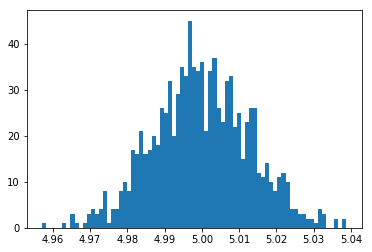

In [245]:
plt.hist(x_values,bins=75);

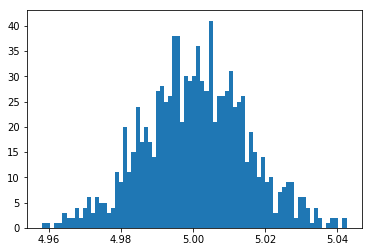

In [246]:
plt.hist(y_values,bins=75);

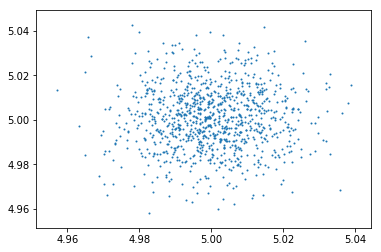

In [247]:
plt.scatter(x_values, y_values, s=1)

In [256]:
np.std(y_values)

0.014377951237823408

In [257]:
np.mean(y_err)

0.0015032703581854274

In [15]:
data_frame =  pd.DataFrame({'x values': x_values,
                            'y values': y_values,
                            'x std. from fit': x_err,
                            'y std. from fit': y_err})

In [16]:
data_frame.to_csv('1000simulatedfitsseparation2pixelsequalflux.csv')

In [10]:
x_values = np.asarray(fits)[:,1]
y_values = np.asarray(fits)[:,2]
x_err = np.asarray(covariance)[:,1]
y_err = np.asarray(covariance)[:,2]

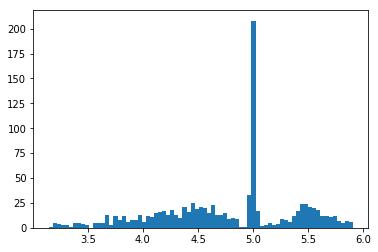

In [11]:
plt.hist(x_values,bins=75);

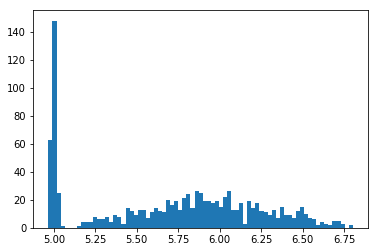

In [12]:
plt.hist(y_values,bins=75);

In [12]:
np.std(np.sqrt(np.square(x_values)+np.square(y_values)))

0.07513687161220235

In [16]:
np.mean(np.sqrt(np.square(x_err)+np.square(y_err)))

0.017022383588544042

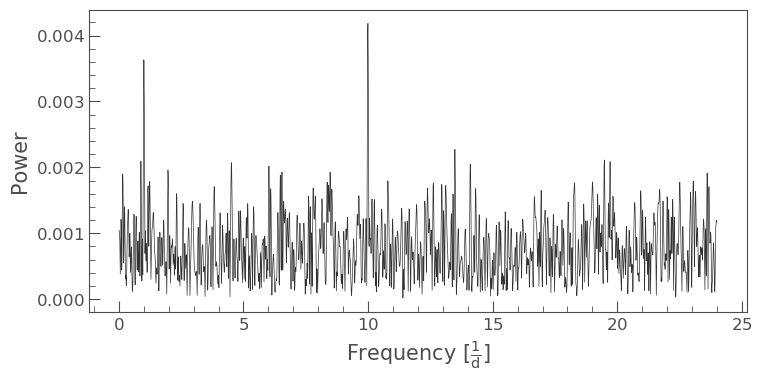

In [149]:
pg[5][5].plot()

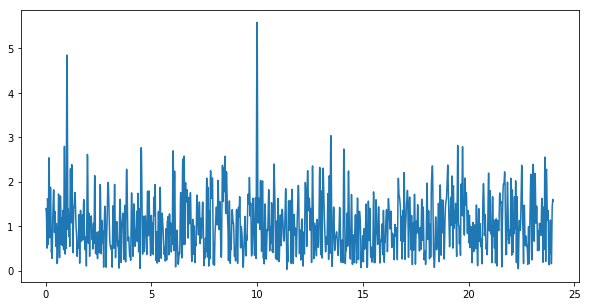

In [148]:
plt.figure(figsize=(10,5))
plt.plot(np.asarray(pg[5][5].frequency), np.asarray(pg[5][5].power)/np.nanmedian(np.asarray(pg[5][5].power)))

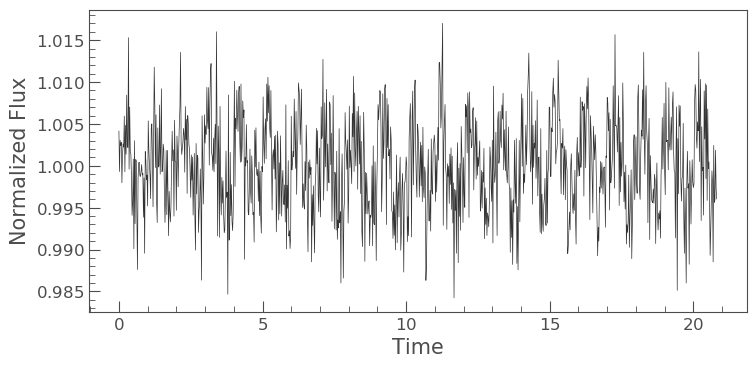

In [139]:
lc[5][5].plot()

---break

In [835]:
image = Simulate_Random_Image(separation=.5,star1flux=100, star2flux=100)
lc = Create_LightCurve(image)
pg = Create_Periodogram(lc)


In [845]:
corrector = lk.RegressionCorrector(lc)

AttributeError: module 'lightkurve' has no attribute 'RegressionCorrector'

In [843]:
image['SNR']

array([[ 3.16247258,  3.15111808,  3.15899011,  3.18919083,  3.15801336,
         3.15366332,  3.15982498,  3.15271874,  3.16506606,  3.16335296,
         3.16977489],
       [ 3.14355925,  3.16620059,  3.15656199,  3.14142139,  3.16962507,
         3.17918358,  3.15424482,  3.13688897,  3.1518885 ,  3.17400918,
         3.17824038],
       [ 3.17933657,  3.17240294,  3.15714009,  3.19456536,  3.30467813,
         3.44269944,  3.29802087,  3.16949373,  3.1951843 ,  3.18458799,
         3.16661736],
       [ 3.16955768,  3.16490055,  3.15278311,  3.80046163,  8.67333444,
        13.16931898,  9.21171943,  4.02467306,  3.17519113,  3.19144131,
         3.13330465],
       [ 3.15715721,  3.14749395,  3.27671206,  8.55189356, 30.63832188,
        48.69583357, 32.92790353, 10.08272267,  3.38807963,  3.16125282,
         3.18800999],
       [ 3.15681203,  3.1741247 ,  3.46135969, 12.81681007, 47.63937323,
        75.85752374, 51.20038345, 15.30249308,  3.71534399,  3.16420258,
         3.155

In [756]:
np.var(lc[0][0].flux)

9.991426634764267

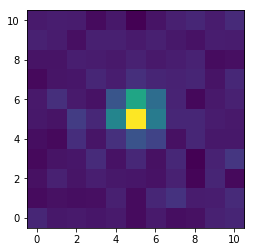

In [836]:
plt.imshow(image['stars'][0],origin=0)

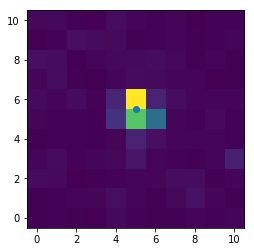

In [837]:
fhp = frequency_heatmap(pg,1000/48,[5])
plt.imshow(fhp,origin=0)
plt.scatter(loc[0][1],loc[0][2])

In [759]:
fhp[0][0]

0.7645565297670209

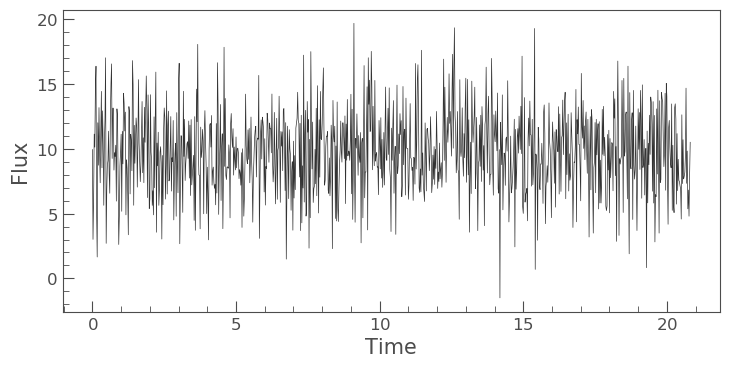

In [760]:
lc[0][0].plot()

In [794]:
(pg[5][5].power)*scalingf

<Quantity [  7.59786337, 842.24103164] d>

In [793]:
scalingf = 2/(np.var(lc[5][5].flux)/24)

In [827]:
(np.var(lc[5][5].flux)/24)

983.6259599031896

sample variance as the mean over a bunch of small increments in the time series?

In [814]:
(np.var(lc[5][5].flux[21:24])/24)

955.4999269604917

In [336]:
stats.chi2.sf(151,2)

1.6246754435760903e-33

In [773]:
stats.chi2.isf(0.022750131948179195,2)

7.566368667364064

In [772]:
stats.norm.sf(2)

0.022750131948179195

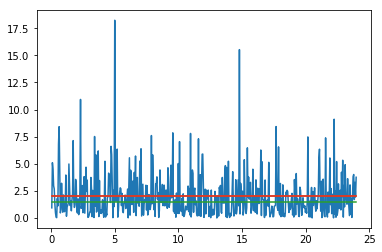

In [841]:
periodogrampixel = pg[5][6]
plt.plot(periodogrampixel.frequency,periodogrampixel.power)

plt.plot(periodogrampixel.frequency,np.ones(499)*np.mean(periodogrampixel.power))
plt.plot(periodogrampixel.frequency,np.ones(499)*np.median(periodogrampixel.power))
plt.plot(periodogrampixel.frequency,np.ones(499)*(np.var(lc[5][6].flux)/24))

#plt.yscale('log')

In [719]:
loc = tdg_fit(fhp)
loc[0][1],loc[0][2]

(5.035310042328445, 5.503738685938177)

In [768]:
np.mean(periodogrampixel.power),np.median(periodogrampixel.power)

(<Quantity 1727.06603731 d>, <Quantity 177.26960927 d>)

# NEW METHOD:

## Functions:

In [1]:
import warnings
import numpy as np
from astropy.stats import sigma_clip
import os
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import lightkurve as lk
from scipy import stats
from astropy import units as u
import scipy.optimize as opt
from photutils import centroids as cent
import lmfit as lm
from lmfit import Minimizer, Parameters, report_fit
from tqdm import tqdm_notebook

In [32]:

def Simulate_Random_Image(imageshape=(11,11),separation=None,backgroundnoise=10,star1flux = 1000,star2flux = 1000,star1pos=[5,5]):
    time = np.arange(1000)*1./48.
    freq1 = 10 #per day
    freq2 = 5 #per day
    relamp = .01
    signal1 = relamp * np.sin(time*2*np.pi*freq1)
    signal2 = .01 * np.sin(time*2*np.pi*freq2) #+ stats.norm.rvs(len(time))*.01
    
    

    #Images
    if(separation == None):
        star1pos = [np.random.uniform()*imageshape[0],np.random.uniform()*imageshape[1]]
        star2pos = [np.random.uniform()*imageshape[0],np.random.uniform()*imageshape[1]]
        star1flux = np.random.randint(300,2000)
        star2flux = np.random.randint(300,2000)
        seeingsigma = 1.
        
        imagestack = np.zeros((imageshape[0],imageshape[1],len(time)))
        xcoord,ycoord = np.meshgrid(np.arange(imageshape[1]),np.arange(imageshape[0])) #strange order



        

        #add starlight

        distance1 = np.sqrt((xcoord-star1pos[0])**2 + (ycoord-star1pos[1])**2)
        distance2 = np.sqrt((xcoord-star2pos[0])**2 + (ycoord-star2pos[1])**2)

        for i in range(len(time)):
            #star 1
            imagestack[:,:,i] += stats.norm.pdf(distance1,scale=seeingsigma) * star1flux * (1. + signal1[i])

            #star 2
            imagestack[:,:,i] += stats.norm.pdf(distance2,scale=seeingsigma) * star2flux * (1. + signal2[i])

            #add measurement noise
            #should probably be Poisson
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(imagestack[:,:,i])

            #background
            imagestack[:,:,i] += backgroundnoise
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(backgroundnoise)

        stars = imagestack[:,:,:].T
        return [stars,freq1,freq2,star1pos,star2pos,star1flux,star2flux,time,imageshape,separation]
        
        
    else:
        #star1pos = [5,5]#[np.random.uniform()*imageshape[0],np.random.uniform()*imageshape[1]]
        star2pos = [star1pos[0],star1pos[1]+separation]#[np.random.uniform(star1pos[0]-separation,star1pos[0]+separation,size=1)]
        #star2pos.extend(np.random.choice((-1,1))*np.sqrt(separation**2 - (star2pos[0]-star1pos[0])**2)+star1pos[1])
        #star1flux = 1000#np.random.randint(300,2000)
        #star2flux = 1000#np.random.randint(300,2000)
        seeingsigma = 1

        imagestack = np.zeros((imageshape[0],imageshape[1],len(time)))
        ycoord,xcoord = np.meshgrid(np.arange(imageshape[1]),np.arange(imageshape[0])) #strange order




        #add starlight

        distance1 = np.sqrt((xcoord-star1pos[0])**2 + (ycoord-star1pos[1])**2)
        distance2 = np.sqrt((xcoord-star2pos[0])**2 + (ycoord-star2pos[1])**2)

        for i in range(len(time)):
            #star 1
            imagestack[:,:,i] += stats.norm.pdf(distance1,scale=seeingsigma) * star1flux * (1. + signal1[i])

            #star 2
            imagestack[:,:,i] += stats.norm.pdf(distance2,scale=seeingsigma) * star2flux * (1. + signal2[i])

            #add measurement noise
            #should probably be Poisson
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(imagestack[:,:,i])

            #background
            imagestack[:,:,i] += backgroundnoise
            imagestack[:,:,i] += stats.norm.rvs(size=imagestack[:,:,i].size).reshape(imageshape) * np.sqrt(backgroundnoise)
        
        stars = imagestack[:,:,:].T
        
        

    diction = {
        'stars':stars,
        'Frequencystar1':freq1,
        'Frequencystar2':freq2,
        'star1position':star1pos,
        'star2position':star2pos,
        'star1flux':star1flux,
        'star2flux':star2flux,
        'time':time,
        'imageshape':imageshape,
        'separation':separation
    }
    return diction

In [3]:
#not worried about PCA since there shouldnt be systematic trends to get rif of
def Create_LightCurve(*simulatedimage):
    imageshape = simulatedimage[0]['imageshape']
    time = simulatedimage[0]['time']
    lc_array = np.zeros(imageshape,dtype=object)
    fluxtype = simulatedimage[0]['stars']
    for i in np.arange(0,imageshape[0]):
        for j in np.arange(0,imageshape[1]):
            lc_array[j][i] = lk.LightCurve(time = time, flux = fluxtype.T[i,j,:])
            #lc_array[j][i] = lc_array[j][i].normalize()
    return lc_array

In [4]:
def Obtain_Initial_Phase(corrected_lc,frequency_list):

    flux = corrected_lc.flux
    times = corrected_lc.time - np.mean(corrected_lc.time)
    pg = corrected_lc.to_periodogram(frequency = frequency_list,ls_method='slow')
    initial_flux= np.asarray(pg.power)

    initial_phase = np.zeros(len(frequency_list))

    def lc_model(time,amp,freq,phase):
        return amp*np.sin(2*np.pi*freq*time + phase)

    def background_model(time,height):
        return time*height/time
    for j in np.arange(len(frequency_list)):
        for i in np.arange(len(frequency_list)):

            if (i == 0):
                model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
                model += lm.Model(background_model, independent_vars=['time'])
            else:
                model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


            model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phase[i],vary = False)
            model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=False)
            model.set_param_hint('height', value= np.mean(flux),vary=False)
            model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


        params = model.make_params()
        params['f{0:d}phase'.format(j)].set(vary=True)
        params['f{0:d}phase'.format(j)].set(value = initial_phase[j])
        params['f{0:d}phase'.format(j)].set(brute_step=np.pi/10)
        result = model.fit(corrected_lc.flux,params,time=times,method = 'brute')
        initial_phase[j]=result.best_values['f{0:d}phase'.format(j)]

    return initial_phase



def Obtain_Final_Phase(corrected_lc,frequency_list,initial_phases):

    flux = corrected_lc.flux
    times = corrected_lc.time - np.mean(corrected_lc.time)
    pg = corrected_lc.to_periodogram(frequency = frequency_list)
    initial_flux= np.asarray(pg.power)


    def lc_model(time,amp,freq,phase):
        return amp*np.sin(2*np.pi*freq*time + phase)

    def background_model(time,height):
        return time*height/time

    for i in np.arange(len(frequency_list)):

        if (i == 0):
            model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
            model += lm.Model(background_model, independent_vars=['time'])
        else:
            model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


        model.set_param_hint('f{0:d}phase'.format(i), min = -np.pi, max = np.pi ,value= initial_phases[i],vary = True)
        model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=True)
        model.set_param_hint('height', value= np.mean(flux),vary=True)
        model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


    params = model.make_params()

    result = model.fit(corrected_lc.flux,params,time=times)

    final_phases = [result.best_values['f{0:d}phase'.format(j)] for j in np.arange(len(frequency_list))]


    return final_phases



def Obtain_Final_Fit(corrected_lc,frequency_list,final_phases):

    flux = corrected_lc.flux
    times = corrected_lc.time - np.mean(corrected_lc.time)
    pg = corrected_lc.to_periodogram(frequency = frequency_list)
    initial_flux= np.asarray(pg.power)


    def lc_model(time,amp,freq,phase):
        return amp*np.sin(2*np.pi*freq*time + phase)

    def background_model(time,height):
        return time*height/time

    for i in np.arange(len(frequency_list)):

        if (i == 0):
            model = lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i)) 
            model += lm.Model(background_model, independent_vars=['time'])
        else:
            model += lm.Model(lc_model,independent_vars=['time'],prefix='f{0:d}'.format(i))


        model.set_param_hint('f{0:d}phase'.format(i), value= final_phases[i],vary = False)
        model.set_param_hint('f{0:d}amp'.format(i), value = initial_flux[i],vary=True)
        model.set_param_hint('height', value= np.mean(flux),vary=True)
        model.set_param_hint('f{0:d}freq'.format(i),value = frequency_list[i], vary = False)


    params = model.make_params()

    result = model.fit(corrected_lc.flux,params,time=times)

    return result




In [5]:
def centroid(image,heat_stamp,heatmap_error,frequencies):

    size = image['imageshape']
    #Residuals to minimize relative to the error bars
    def residual(params, amp, amperr):

        x = params['x']
        y = params['y']
        sigma = params['sigma']

        xpix,ypix = np.meshgrid(np.arange(size[0]),np.arange(size[1]))

        res = []
        for i in np.arange(len(frequencies)):
            height = params['height{0:d}'.format(i)]

            model = height*np.exp(-(((x-xpix)/sigma)**2+((y-ypix)/sigma)**2)/2)

            res.extend( [(amp[i].reshape(size)-model) / amperr[i].reshape(size)])


        return np.asarray(res)

    #Set starting values to converge from
    c = cent.centroid_2dg(heat_stamp.sum(axis=0).reshape(size) / np.sqrt((heatmap_error**2).sum(axis=0)).reshape(size))
    params = Parameters()
    for i in np.arange(len(frequencies)):
        params.add('height{0:d}'.format(i), value=np.max(heat_stamp[i]))
    params.add('x', value=c[0]) 
    params.add('y', value=c[1])
    params.add('sigma', value=1)

    #Do the fit
    minner = Minimizer(residual, params, fcn_args=(heat_stamp, heatmap_error))
    
    result = minner.minimize()
    fit = result.params.valuesdict()
    x = fit['x']
    y = fit['y']
    composite_heatmap = heat_stamp.sum(axis=0).reshape(size[0],size[1]) / np.sqrt((heatmap_error**2).sum(axis=0)).reshape(size[0],size[1])
    diction ={
        'result':result,
        'fit':fit,
        'centroid':(x,y),
        'composite heatmap':composite_heatmap
    }
    return diction

## Process

In [33]:
#create image 
image = Simulate_Random_Image(separation=3)

In [34]:
#create lightcurve
lightcurve = Create_LightCurve(image)

In [35]:
#phase fits
frequency_list = [1,5]
initial_phases = Obtain_Initial_Phase(sum(sum(lightcurve)),frequency_list)
final_phases = Obtain_Final_Phase(sum(sum(lightcurve)),frequency_list, initial_phases)


In [36]:
#obtain 'heats'
heats = []
heats_error =[]
imageshape = image['imageshape']
#Iterating through columns of pixels
for i in np.arange(0,imageshape[0]):

    #Iterating through rows of pixels
    for j in np.arange(0,imageshape[1]):


        #Making an empty 2-d array
        mask = np.zeros((imageshape[0],imageshape[1]), dtype=bool)

        #Iterating to isolate pixel by pixel to get light curves
        mask[i][j] = True

        #Getting the light curve for a pixel and excluding any flagged data
        lc = lightcurve[mask][0]





        bestfit = Obtain_Final_Fit(lc,frequency_list,final_phases)
        heat = np.asarray([bestfit.best_values['f{0:d}amp'.format(n)] for n in np.arange(len(frequency_list))])
        #heat = bestfit.best_values['f0amp']# / bestfit.params['f0amp'].stderr
        heat_error =  np.asarray([bestfit.params['f{0:d}amp'.format(n)].stderr for n in np.arange(len(frequency_list))])

        #Extending the list of fitting data for each pixel
        heats.extend([heat])
        heats_error.extend([heat_error])

#Taking the final list and turning it into a 2-d numpy array with the same dimensions of the full postage stamp      
#heats = np.reshape(np.asarray(heats),(len(self.aperture),len(self.aperture[0])))
#heats_error = np.reshape(np.asarray(heats_error),(len(self.aperture),len(self.aperture[0])))
heats = np.asarray(heats)
heats_error = np.asarray(heats_error)

#Defining self.periodogram as this 2-d array of periodogram data
heatmap = heats.T
heatmap_error = heats_error.T




In [37]:
centroidfit = centroid(image,heatmap,heatmap_error,frequency_list)

In [45]:
centroidfit['result'].params

name,value,standard error,relative error,initial value,min,max,vary
height0,0.38075302,0.29716120,(78.05%),1.2325878557572767,-inf,inf,True
height1,3.35777012,0.45185192,(13.46%),4.542120915059098,-inf,inf,True
x,4.98439438,0.09956295,(2.00%),4.567717520550738,-inf,inf,True
y,8.07376030,0.12137086,(1.50%),8.335696474763921,-inf,inf,True
sigma,1.16288850,0.06731819,(5.79%),1,-inf,inf,True


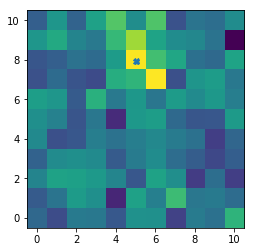

In [81]:
plt.imshow(centroidfit['composite heatmap'],origin=0)
plt.plot(centroidfit['centroid'][0],centroidfit['centroid'][1],marker='X')

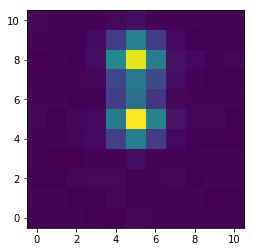

In [82]:
plt.imshow(image['stars'][0],origin=0)

In [83]:
report_fit(centroidfit['result'])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 242
    # variables        = 5
    chi-square         = 206.768503
    reduced chi-square = 0.87244094
    Akaike info crit   = -28.0757721
    Bayesian info crit = -10.6310835
[[Variables]]
    height0:  0.26728577 +/- 0.50772351 (189.96%) (init = 1.036278)
    height1:  5.08952979 +/- 0.76702528 (15.07%) (init = 5.392311)
    x:        5.01263772 +/- 0.07922213 (1.58%) (init = 5.134497)
    y:        7.94711435 +/- 0.08544119 (1.08%) (init = 8.205188)
    sigma:    0.77810478 +/- 0.04937526 (6.35%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(height1, sigma) = -0.750
    C(y, sigma)       = -0.106


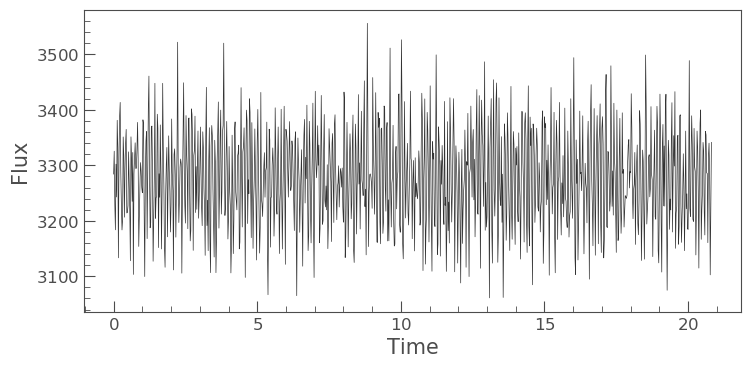

In [28]:
sum(sum(lightcurve)).plot()

Cases to test:
1. different percent variability
2. different brightnesses

In [77]:
frequency_list = [1,5]
fitsx = []
fitsy = []
xerr = []
yerr = []
positionx = []
positiony = []

for j in tqdm_notebook(np.arange(5,10,.5)):

    for i in tqdm_notebook(np.arange(0,1000)):
        image = Simulate_Random_Image(separation=1,star1flux=1000,star2flux=0,star1pos=[5,j])
        lc = Create_LightCurve(image)
        initial_phases = Obtain_Initial_Phase(sum(sum(lightcurve)),frequency_list)
        final_phases = Obtain_Final_Phase(sum(sum(lightcurve)),frequency_list, initial_phases)
        #obtain 'heats'
        heats = []
        heats_error =[]
        imageshape = image['imageshape']
        #Iterating through columns of pixels
        for i in np.arange(0,imageshape[0]):

            #Iterating through rows of pixels
            for j in np.arange(0,imageshape[1]):


                #Making an empty 2-d array
                mask = np.zeros((imageshape[0],imageshape[1]), dtype=bool)

                #Iterating to isolate pixel by pixel to get light curves
                mask[i][j] = True

                #Getting the light curve for a pixel and excluding any flagged data
                lc = lightcurve[mask][0]





                bestfit = Obtain_Final_Fit(lc,frequency_list,final_phases)
                heat = np.asarray([bestfit.best_values['f{0:d}amp'.format(n)] for n in np.arange(len(frequency_list))])
                #heat = bestfit.best_values['f0amp']# / bestfit.params['f0amp'].stderr
                heat_error =  np.asarray([bestfit.params['f{0:d}amp'.format(n)].stderr for n in np.arange(len(frequency_list))])

                #Extending the list of fitting data for each pixel
                heats.extend([heat])
                heats_error.extend([heat_error])

        #Taking the final list and turning it into a 2-d numpy array with the same dimensions of the full postage stamp      
        #heats = np.reshape(np.asarray(heats),(len(self.aperture),len(self.aperture[0])))
        #heats_error = np.reshape(np.asarray(heats_error),(len(self.aperture),len(self.aperture[0])))
        heats = np.asarray(heats)
        heats_error = np.asarray(heats_error)

        #Defining self.periodogram as this 2-d array of periodogram data
        heatmap = heats.T
        heatmap_error = heats_error.T
        centroidfit = centroid(image,heatmap,heatmap_error,frequency_list)

        fitsx[0:0]=[centroidfit['result'].params['x'].value]
        fitsy[0:0]=[centroidfit['result'].params['y'].value]
        xerr[0:0]=[centroidfit['result'].params['x'].stderr]
        yerr[0:0]=[centroidfit['result'].params['y'].stderr]
        positionx[0:0] = [5]
        positiony[0:0] = [j]

data_frame =  pd.DataFrame({'real x':np.asarray(positionx),
                            'real y':np.asarray(positiony),
                            'x fit': np.asarray(fitsx),
                            'y fit': np.asarray(fitsy),
                            'x stderr': np.asarray(xerr),
                            'y stderr': np.asarray(yerr)})
    

data_frame.to_csv('1000simulatedfits_1stardifferentpositions.csv')

<ipython-input-77-2c7d439babe2>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for j in tqdm_notebook(np.arange(5,10,.5)):


<ipython-input-77-2c7d439babe2>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.arange(0,1000)):


KeyboardInterrupt: 

In [65]:
centroidfit['result'].params['x'].stderr

0.09956294719709274

In [71]:
bb = []

In [74]:
bb[0:0] =[centroidfit['result'].params['x'].value]

In [75]:
bb

[4.984394377502756]